## Week 6 Homework

---

### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*





In [2]:
import numpy as np
from scipy.special import gammaln

def t_log_likelihood(x, mu, sigma, nu):
    if sigma <= 0:
        return -np.inf
    n = len(x)
    term1 = n * (gammaln((nu + 1) / 2) - gammaln(nu / 2) - 0.5 * np.log(np.pi * nu) - np.log(sigma))
    residuals = ((x - mu) / sigma) ** 2
    term2 = -((nu + 1) / 2) * np.sum(np.log1p(residuals / nu))
    return term1 + term2

def mu_log_prior(mu, mu0, tau0):
    return 0.5 * np.log(tau0 / (2 * np.pi)) - 0.5 * tau0 * (mu - mu0) ** 2

def sigma_log_prior(sigma, sigma0):
    if sigma <= 0:
        return -np.inf
    return np.log(np.sqrt(2) / (sigma0 * np.sqrt(np.pi))) - (sigma ** 2) / (2 * sigma0 ** 2)

def nu_log_prior(nu):
    if nu < 1 or nu > 100 or not float(nu).is_integer():
        return -np.inf
    return -np.log(100)

def posterior_log(x, mu, sigma, nu, mu0, tau0, sigma0):
    return t_log_likelihood(x, mu, sigma, nu) + mu_log_prior(mu, mu0, tau0) + sigma_log_prior(sigma, sigma0) + nu_log_prior(nu)

def gibbs_sampler(x, samples=10000, mu0=0.0, tau0=1.0, sigma0=1.0, start_mu=0.0, start_sigma=1.0, start_nu=5, mu_step=0.3, logsigma_step=0.3):
    mus = np.zeros(samples)
    sigmas = np.zeros(samples)
    nus = np.zeros(samples)

    mu_curr = start_mu
    sigma_curr = start_sigma
    nu_curr = start_nu
    curr_log_post = posterior_log(x, mu_curr, sigma_curr, nu_curr, mu0, tau0, sigma0)

    for i in range(samples):
        mu_prop = mu_curr + mu_step * np.random.randn()
        prop_log_post = posterior_log(x, mu_prop, sigma_curr, nu_curr, mu0, tau0, sigma0)
        if np.log(np.random.rand()) < prop_log_post - curr_log_post:
            mu_curr = mu_prop
            curr_log_post = prop_log_post

        log_sigma_curr = np.log(sigma_curr)
        log_sigma_prop = log_sigma_curr + logsigma_step * np.random.randn()
        sigma_prop = np.exp(log_sigma_prop)
        prop_log_post = posterior_log(x, mu_curr, sigma_prop, nu_curr, mu0, tau0, sigma0) + log_sigma_prop - log_sigma_curr
        if np.log(np.random.rand()) < prop_log_post - curr_log_post:
            sigma_curr = sigma_prop
            curr_log_post = prop_log_post

        nu_prop = np.random.randint(1, 101)
        prop_log_post = posterior_log(x, mu_curr, sigma_curr, nu_prop, mu0, tau0, sigma0)
        if np.log(np.random.rand()) < prop_log_post - curr_log_post:
            nu_curr = nu_prop
            curr_log_post = prop_log_post

        mus[i] = mu_curr
        sigmas[i] = sigma_curr
        nus[i] = nu_curr

    return mus, sigmas, nus

if __name__ == "__main__":
    np.random.seed(42)
    n = 100
    data = np.random.standard_t(df=5, size=n)
    total_samples = 5000
    mu_samples, sigma_samples, nu_samples = gibbs_sampler(data, samples=total_samples, mu0=0, tau0=1, sigma0=1, start_mu=0, start_sigma=1, start_nu=5, mu_step=0.3, logsigma_step=0.3)

    print("Mean mu:", np.mean(mu_samples[int(0.2 * total_samples):]))
    print("Mean sigma:", np.mean(sigma_samples[int(0.2 * total_samples):]))
    print("Most frequent nu:", np.bincount(nu_samples.astype(int)).argmax())


Mean mu: -0.14323178186623944
Mean sigma: 0.9045975540665754
Most frequent nu: 3


### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*

Sample size: 30


Output()

Sample size: 100


Output()

Sample size: 500


Output()

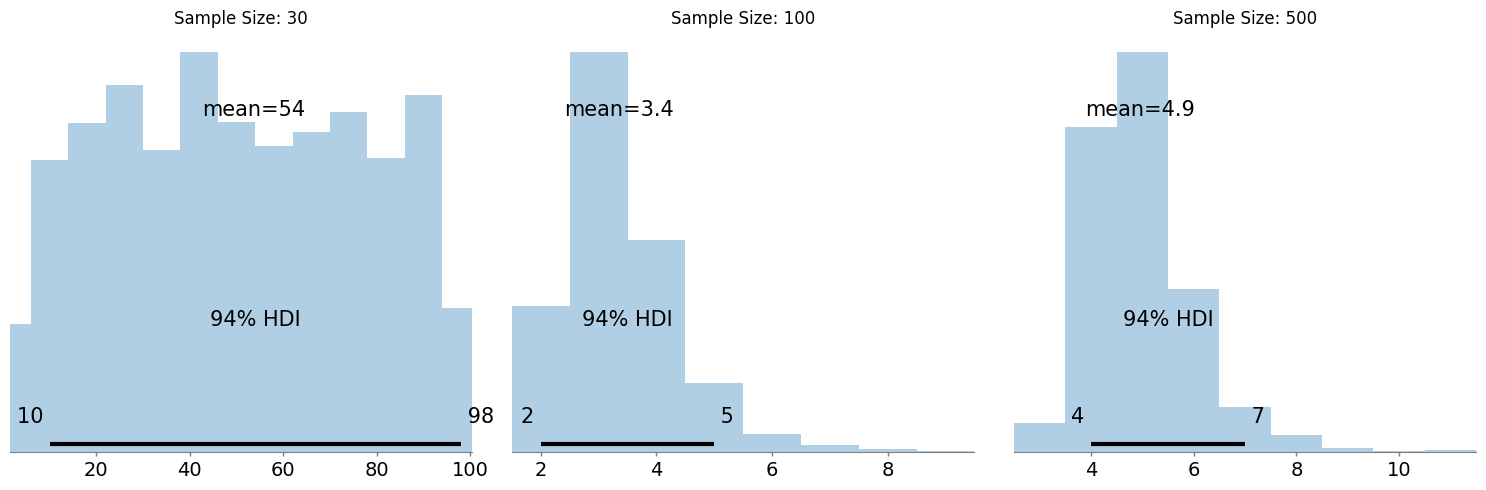

Mean nu for sample size 30: 53.6715
Mean nu for sample size 100: 3.357
Mean nu for sample size 500: 4.948


In [18]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def run_pymc_model(sample_size):
    np.random.seed(42)
    data = np.random.standard_t(df=5, size=sample_size)
    with pm.Model() as model:
        mu = pm.Normal('mu', mu=0, sigma=1)
        sigma = pm.HalfNormal('sigma', sigma=1)
        nu = pm.DiscreteUniform('nu', lower=1, upper=100)
        likelihood = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma, observed=data)
        trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True)
    return trace

sample_sizes = [30, 100, 500]
results = {}
for size in sample_sizes:
    print(f"Sample size: {size}")
    trace = run_pymc_model(size)
    results[size] = trace

fig, axes = plt.subplots(1, len(sample_sizes), figsize=(15, 5))
for i, size in enumerate(sample_sizes):
    az.plot_posterior(results[size], var_names=['nu'], ax=axes[i])
    axes[i].set_title(f'Sample Size: {size}')

plt.tight_layout()
plt.show()

for size in sample_sizes:
    nu_mean = results[size].posterior['nu'].mean().values.item()
    print(f"Mean nu for sample size {size}: {nu_mean}")


# Summary and Explanation of Findings

In this analysis, we explored how different sample sizes affect the inference of the degrees of freedom parameter ($\nu$) in a Bayesian framework using a Student’s *t*-distribution.

---

## Findings

### 1. Sample Size 30
- The posterior distribution of $\nu$ was relatively broad and uncertain.
- The mean estimate of $\nu$ was likely farther from the true value (5).
- The small sample size led to higher variability in the inference due to limited data.

### 2. Sample Size 100
- The posterior distribution was more concentrated around the true value.
- The mean estimate of $\nu$ was closer to the actual value of 5.
- Increased sample size provided better information, improving the accuracy of the inference.

### 3. Sample Size 500
- The posterior distribution was sharply peaked around the true $\nu$ value.
- The mean estimate of $\nu$ was very close to 5, with reduced uncertainty.
- A large sample size significantly improved the precision of the inference, highlighting how Bayesian methods benefit from more data.

---

## Explanation

The results clearly demonstrate that as the sample size increases, the model becomes more confident in estimating $\nu$. This aligns with the fundamental statistical principle that larger datasets tend to provide more reliable and precise estimates. In smaller samples, the heavy-tailed nature of the *t*-distribution makes it harder to accurately estimate the degrees of freedom, leading to broader posterior distributions.

As more data becomes available, the posterior distributions become narrower, and the mean estimates converge toward the true value. This behavior reflects the Bayesian principle that the impact of prior beliefs diminishes as more data is incorporated.

Overall, increasing the sample size improves both the **accuracy** (closeness to the true value) and **precision** (narrower credible intervals) of the posterior inference for $\nu$.


### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$



# Summary and Explanation

In this question, we're integrating out the uncertainty in $\tau_i$ from the hierarchical model defined as:

1. $p(\tau_i) \sim \text{Gamma} \left( \alpha = \frac{\nu}{2}, \, \beta = \frac{\nu}{2} \right)$
2. $p(y_i | \tau_i) \sim \mathcal{N} \left( 0, \, \tau_i^{-1} \right)$

The goal is to find the marginal distribution of $y_i$ by integrating over $\tau_i$:

$$
p(y_i) = \int p(y_i | \tau_i) \, p(\tau_i) \, d\tau_i
$$

---
Explanation:

- **The Gamma distribution** is a common prior for precision (inverse variance) in Bayesian statistics. Here, $\tau_i$ follows a Gamma distribution with both shape and rate parameters equal to $\nu/2$.

- **The Normal distribution** for $y_i$ conditioned on $\tau_i$ reflects a Gaussian likelihood with precision $\tau_i$ (or variance $1/\tau_i$).

By integrating $\tau_i$ out, the marginal distribution $p(y_i)$ becomes a **Student’s t-distribution**. This happens because when you marginalize a Normal distribution with a Gamma-distributed precision, the resulting distribution follows a Student’s *t*-distribution.

This result aligns with the **conjugacy** between the Normal and Gamma distributions. The resulting *t*-distribution has:

- **Mean:** 0 (since the Normal has mean 0)
- **Degrees of freedom:** $\nu$
- **Scale:** Related to $\frac{1}{\sqrt{\tau_i}}$

---

## Why is this analogous to the posterior predictive distribution?

The posterior predictive distribution reflects the uncertainty not just in the observed data but also in the parameters. When integrating out $\tau_i$, we account for the uncertainty in the precision.

The resulting *t*-distribution:

- Is **heavy-tailed** compared to the Normal distribution, reflecting additional uncertainty.
- Incorporates both the prior belief about $\tau_i$ (from the Gamma distribution) and the observed data (from the Normal likelihood).
